<a href="https://colab.research.google.com/github/arpanbiswas52/pcVAEBO_pyrochlore/blob/main/data/pcVAESAASBO_Ho2Ti2O7(8D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Refinement of the Structure parameters of SpinIce model (Ho2Ti2O7)



#Problem Description

Build a pc-VAE-SAASBO framework where SAASBO is adapted from https://botorch.org/docs/tutorials/saasbo/ -

- Here we have an experimental set up of refinement of structure parameters of Spin Ice model, to match the experimental results of X-ray diffraction.

- The goal is to do an automated experiment set up through BO model- where we sequnetially learn and adaptively sample towards region of best structure parameters (theory-experiment matching).

- In this notebook, we explored with high-D SAASBO with all 8 control parameters $OccTi$, $UTi$, $OccHo$, $UHo$, $xO1$, $OccO1$, $UO1$, $UO2$

- Here, we utilized the starting sample with the best samples obtained from previous 4D and 2D pcVAEBO explorations


In [ ]:
# NECESSARY MODULES

#!pip install gpytorch
#!pip install smt
#!pip install scikit-image
#!pip install numpy==1.26.4
#!pip install scipy==1.14.0
#!pip install matplotlib
#!pip install pillow==10.3.0
#!pip install torchvision

In [ ]:
#@title Imports
import torch
from torchvision import datasets, transforms
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Import GP and BoTorch functions
import gpytorch as gpt
from botorch.utils import standardize
from botorch.acquisition import UpperConfidenceBound
from botorch.sampling import IIDNormalSampler
from botorch.sampling import SobolQMCNormalSampler

from smt.sampling_methods import LHS
from torch.optim import SGD
from torch.optim import Adam
from scipy.stats import norm
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Import GSAS modules
import os
import sys
sys.path.insert(0, os.path.expanduser(r"C:\Users\USER\gsas2full\GSAS-II\GSASII"))
import GSASIIscriptable as G2sc
from gsas import gsas
import torch.nn as nn

#For experimental analysis

#import WSe2_Target_Extractor as target - Talk to sumner can we import this?

C:\Users\USER\anaconda3\envs\gsas2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GSAS-II binary directory: C:\Users\USER\gsas2full\GSAS-II\GSASII-bin\win_64_p3.11_n1.26


In [ ]:
import botorch
print(botorch.__version__)

0.14.0


In [ ]:
# Imports adapted from SAASBO
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

import os

import torch
from torch.quasirandom import SobolEngine

from botorch import fit_fully_bayesian_model_nuts
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.test_functions import Branin

SMOKE_TEST = os.environ.get("SMOKE_TEST")

tkwargs = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "dtype": torch.double,
}

WARMUP_STEPS = 256 if not SMOKE_TEST else 32
NUM_SAMPLES = 128 if not SMOKE_TEST else 16
THINNING = 16

In [ ]:
# Define the Variational Autoencoder (VAE) architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1000),
            nn.ReLU(),
            nn.Linear(1000, input_dim),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        logvar = torch.clamp(logvar, min=-10, max=10)  # Clamp to prevent large values
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        decoded = self.decoder(z)
        return torch.abs(decoded)  # Apply absolute value to ensure non-negative outputs

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

# Define loss function
def loss_function(reconstructed, original, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(reconstructed, original, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

# Initialize weights with Xavier initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

# Function to train the VAE with loss tracking for convergence plot
def train_vae(vae, dataloader, epochs=2000, lr=0.0001):
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    vae.train()
    loss_history = []  # To store loss for each epoch

    for epoch in range(epochs):
        train_loss = 0
        for batch in dataloader:
            batch_data = batch[0]
            optimizer.zero_grad()
            reconstructed, mu, logvar = vae(batch_data)

            # Calculate the loss
            loss = loss_function(reconstructed, batch_data, mu, logvar)

            # Check for NaN or Inf loss
            if torch.isnan(loss) or torch.isinf(loss):
                print("NaN or Inf loss encountered, stopping training.")
                return

            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)  # Clip gradients
            optimizer.step()
            train_loss += loss.item()

        avg_loss = train_loss / len(dataloader.dataset)
        loss_history.append(avg_loss)  # Append average loss of this epoch
        print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

    # Plot convergence curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_history, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Convergence Curve (Epoch vs. Loss)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Empty arrays to store F_obs and F_calc reflection lists
# Make sure to run this code block again when re-running code to reset arrays and iteration
# Iteration is just for .gpx filenames, you can ignore it if need be or set it const in gsas script
Fobs = []
Fcalc = []
iteration = 0

# Loading the VAE model, pretrained with X-ray data

- The notebook for the VAE model training and analysis can be found at <Arpan- Joseph, add the link for the VAE final notebook>

In [ ]:
vae = torch.load("vae_full_model.pth", weights_only=False)

# Design objective function integrating with pretrained VAE

In [ ]:
def func_obj(X, iteration, pre_trained_model):

    # Run GSAS once to get Fobs_i and Fcalc_i

    #chisq, Fobs_i, Fcalc_i, iteration = gsas(X, fixed_param, iteration)

    _, Fobs_i, Fcalc_i, iteration = gsas(X, iteration)



    # Scaling

    F_obs_arr = np.asarray(Fobs_i, dtype=float)

    obs_arr = (F_obs_arr * 1000) / F_obs_arr[452]



    F_calc_arr = np.asarray(Fcalc_i, dtype=float)

    calc_arr = (F_calc_arr * 1000) / F_calc_arr[452]


    # Latent representation

    vae.eval()

    with torch.no_grad():

        obs_tensor = torch.tensor(obs_arr, dtype=torch.float32).unsqueeze(0)

        mu_o, logvar_o = pre_trained_model.encode(obs_tensor)

        latent_obs = vae.reparameterize(mu_o, logvar_o).squeeze(0)



        calc_tensor = torch.tensor(calc_arr, dtype=torch.float32).unsqueeze(0)

        mu_c, logvar_c = pre_trained_model.encode(calc_tensor)



        num_samples = 10000 # we are sampling 10,000 times from the latent space

        latent_dim = 7 # same as the latent dimension of the pre-trained model

        latent_samples = torch.zeros((num_samples, latent_dim), dtype=torch.float32)



        for k in range(num_samples):

            z_c = vae.reparameterize(mu_c, logvar_c).squeeze(0)

            latent_samples[k] = z_c



        sum_latents_calc = torch.sum(latent_samples, dim=0)

        mean_latent_calc = sum_latents_calc / num_samples



    # chi-square calculation

    diff = latent_obs - mean_latent_calc

    chisq_l = torch.sqrt(torch.sum(diff**2) / (latent_dim - 1))

    print('latent_obs:', latent_obs)

    print('mean_latent_calc:', mean_latent_calc)

    ####################################################################################################################

    diff  = F_obs_arr - F_calc_arr
    chisq = np.sqrt(np.sum(diff**2) / (len(F_obs_arr) - 1))
    chisq = chisq/1000
    print('chisq_scaled:', chisq)


    """

    plt.figure()

    plt.scatter(Fobs_i, Fcalc_i, alpha=0.7, s=10, label='Data Points')

    min_val = min(min(Fobs_i), min(Fcalc_i))

    max_val = max(max(Fobs_i), max(Fcalc_i))

    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')



    plt.xlabel('unscaled Fobs_i')

    plt.ylabel('unscaled Fcalc_i')

    plt.title('unscaled Fobs_i vs unscaled Fcalc_i')

    plt.legend()

    plt.grid(True)

    plt.tight_layout()

    plt.show()

    """

    ####################################################################################################################



    #scaled  Fobs_i vs Fcalc_i plot in the original space

    plt.figure()

    plt.scatter(obs_arr, calc_arr, alpha=0.7, s=10, label='Data Points')

    min_val = min(min(obs_arr), min(calc_arr))

    max_val = max(max(obs_arr), max(calc_arr))

    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')



    plt.xlabel('Fobs_i')

    plt.ylabel('Fcalc_i')

    plt.title('Fobs_i vs Fcalc_i')

    plt.legend()

    plt.grid(True)

    plt.tight_layout()

    plt.show()



    plt.figure()

    for k in range(num_samples):

        plt.plot(range(latent_dim), latent_samples[k], alpha=0.1, linewidth=0.2)

    plt.xlabel('Latent Dimension Index')

    plt.ylabel('Latent Values')

    plt.title('10,000 Latent Realizations')

    plt.grid(True)

    plt.tight_layout()

    plt.show()



    # 10 of the the latent realizations

    print("First 10 latent vectors from the VAE:")

    for i in range(10):

        print(f"Sample {i+1}: {latent_samples[i].tolist()}")



    print("chisq_l:", chisq_l)

    return chisq_l, chisq

In [ ]:
# Calling GSAS script
# def func_obj(X, fixed_param, iteration):
    # chisq, Fobs_i, Fcalc_i, iteration = gsas(X, fixed_param, iteration)

    # Fobs.append(Fobs_i)
    # Fcalc.append(Fcalc_i)

    # return chisq

Below section defines the list of functions (user calls these functions during analysis):
1. Gaussian Process
2. Optimimize Hyperparameter of Gaussian Process (using Adam optimizer)
3. Posterior means and variance computation
4. Acquistion functions for BO- Expected Improvmement

In [ ]:
#Optimize Hyperparameters of GP#
def optimize_hyperparam_trainGP(train_X, train_Y, WARMUP_STEPS, NUM_SAMPLES, THINNING):
    # Gp model fit

    # GP funct adapted from SAASBO
    gp_surro = SaasFullyBayesianSingleTaskGP(
        train_X=train_X,
        train_Y=train_Y.to(torch.float64),
        train_Yvar=torch.full_like(train_Y.to(torch.float64), 1e-6),
        #outcome_transform=Standardize(m=1)
    )
    fit_fully_bayesian_model_nuts(
        gp_surro,
        warmup_steps=WARMUP_STEPS,
        num_samples=NUM_SAMPLES,
        thinning=THINNING,
        disable_progbar=True,
    )

    return gp_surro


#GP posterior predictions#
def cal_posterior(gp_surro, test_X):

    with torch.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
        gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False,
                                                  solves=True), \
        gpt.settings.max_cg_iterations(100), \
        gpt.settings.max_preconditioner_size(80), \
        gpt.settings.num_trace_samples(128):

        y_pred_surro = gp_surro.posterior(test_X)
        y_pred_means = y_pred_surro.mean
        y_pred_vars = y_pred_surro.variance


    return y_pred_means, y_pred_vars


In [ ]:
#EI acquistion function#
def acqmanEI(y_means, y_vars, train_Y, ieval, ismin=False):

    y_means = y_means.detach().numpy()
    y_vars = y_vars.detach().numpy()
    y_std = np.sqrt(y_vars)
    if ismin == "True":
        train_Y = - train_Y
        y_means = - y_means
    fmax = train_Y.max()
    fmax = fmax.detach().numpy()
    best_value = fmax
    EI_val = np.zeros(len(y_vars))
    Z = np.zeros(len(y_vars))
    eta = 0.01
    #print(y_std.shape)

    for i in range(0, len(y_std)):
        if (y_std[i] <=0):
            EI_val[i] = 0
        else:
            Z[i] =  (y_means[i]-best_value-eta)/y_std[i]
            EI_val[i] = (y_means[i]-best_value-eta)*norm.cdf(Z[i]) + y_std[i]*norm.pdf(Z[i])

    # Eliminate evaluated samples from consideration to avoid repeatation in future sampling
    EI_val[ieval] = -1
    acq_val = np.max(EI_val)
    acq_cand = [k for k, j in enumerate(EI_val) if j == acq_val]
    #print(acq_val)
    print("EI:",EI_val)
    #print("ymeans:",y_means)
    #print("best value:", best_value)
    return acq_cand, acq_val, EI_val

#Other list of functions-

1. Evaluate initial data and normalize all data
2. Evaluate functions for new data and augment data

In [ ]:
def normalize_get_initialdata_SpinIce(X, X_norm, num, m):

    # Select starting samples randomly as training data
    np.random.seed(0)
    idx = np.random.randint(0, len(X), num) # insert latin hypercube
    train_X = X[idx]
    train_X_norm = X_norm[idx]

    a = torch.tensor([0.9, 0, 1.0515, 0, 0.421597, 0.920386, 0.008262, 0.00325])
    a_norm = torch.empty((1, X.shape[1]))
    for i in range(0, X.shape[1]):
       a_norm[0, i] = (a[i] - torch.min(X[:, i])) / (torch.max(X[:, i]) - torch.min(X[:, i]))
    train_X = torch.vstack((train_X, a))
    train_X_norm = torch.vstack((train_X_norm, a_norm))

    train_Y = torch.empty((train_X.shape[0], 1))
    train_chisq = torch.empty((train_X.shape[0], 1))
    #print(train_X)
    #print(train_X_norm)

    #Evaluate initial training data
    x = torch.empty((1,train_X.shape[1]))

    for i in range(0, train_X.shape[0]):
        for j in range(0, train_X.shape[1]):
          x[0, j] = train_X[i, j]
        print("Function eval #" + str(m + 1))

        train_Y[i, 0], train_chisq[i, 0] = func_obj(x, iteration, pre_trained_model = vae) # pass to the function where we will connect to experiments
        m = m + 1

    #print(train_Y)

    return train_X, train_X_norm, train_Y, train_chisq, idx, m

In [ ]:
################################Augment data - Existing training data with new evaluated data################################
def augment_newdata_SpinIce(acq_X, acq_X_norm, train_X, train_X_norm, train_Y, train_chisq, m):

    nextX = acq_X
    nextX_norm = acq_X_norm
    #train_X_norm = torch.cat((train_X_norm, nextX_norm), 0)
    #train_X_norm = train_X_norm.double()
    train_X_norm = torch.vstack((train_X_norm, nextX_norm))
    train_X = torch.vstack((train_X, nextX))

    x = torch.empty((1,train_X.shape[1]))
    for j in range(0, train_X.shape[1]):
        x[0, j] = train_X[-1, j]


    print("Function eval #" + str(m + 1))
    next_feval = torch.empty(1, 1)
    next_chisq = torch.empty(1, 1)
    next_feval[0, 0], next_chisq[0, 0] = func_obj(x, iteration, pre_trained_model = vae) # pass to the function where we will connect to experiments
    train_Y = torch.vstack((train_Y, next_feval))
    train_chisq= torch.vstack((train_chisq, next_chisq))

    m = m + 1
    return train_X, train_X_norm, train_Y, train_chisq, m

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np

def plot_iteration_results(train_X, train_X_norm, train_Y, test_X, test_X_norm, y_pred_means, y_pred_vars, i):
    # To minimization
    y_pred_means_mat, y_pred_means_mesh = y_pred_means[0], y_pred_means[1]
    #y_pred_vars_mat, y_pred_vars_mesh = y_pred_vars[0], y_pred_vars[1]

    # Return to original scale
    y_pred_means = y_pred_means*(torch.max(train_Y)-torch.min(train_Y))+ torch.min(train_Y)
    #y_pred_means_mesh = y_pred_means_mesh*(torch.max(train_Y)-torch.min(train_Y))+ torch.min(train_Y)

    # Best solution among the evaluated data
    best_Y = torch.min(train_Y)
    ind = torch.argmin(train_Y)
    X_opt = torch.empty((1,train_X.shape[1]))
    X_opt_norm = torch.empty((1,train_X.shape[1]))
    for j in range(0, train_X.shape[1]):
        X_opt[0, j] = train_X[ind, j]
        X_opt_norm[0, j] = train_X_norm[ind, j]

    # Best estimated solution from GP model considering the non-evaluated solution
    best_estY = torch.min(y_pred_means_mat)
    ind = torch.argmin(y_pred_means_mat)
    X_opt_GP = torch.empty((1,test_X.shape[1]))
    X_opt_GP_norm = torch.empty((1,test_X.shape[1]))
    for j in range(0, test_X.shape[1]):
        X_opt_GP[0, j] = test_X[ind, j]
        X_opt_GP_norm[0, j] = test_X_norm[ind, j]

    # Print results
    print("#########################################################")
    print("Current best solutions at iteration:" + str(i))
    print("Best params among evaluated samples:")
    print(X_opt, torch.round(best_Y, decimals= 2))
    print("Best params from GP map:")
    print(X_opt_GP, torch.round(best_estY, decimals= 2))

    # Define parameter names for 8 parameters (adjust these to your actual parameter names)
    param_names = ['OccTi', 'UTi', 'OccHo', 'UHo', 'xO1', 'OccO2', 'UO1', 'UO2']

    # Define which 3D parameter combinations to plot (selecting meaningful combinations)
    param_combinations = [

        (0, 1, 2),  # Parameters 1, 2, 3

        (0, 3, 4),  # Parameters 1, 4, 5

        (1, 5, 6),  # Parameters 2, 6, 7

        (2, 7, 0),  # Parameters 3, 8, 1

        (3, 6, 1),  # Parameters 4, 7, 2

        (4, 5, 7),  # Parameters 5, 6, 8

    ]


    #train_X, train_X_norm, train_Y, test_X, test_X_norm, y_pred_means, y_pred_vars
    # Create figure with organized layout: means first, then variances

    # 2 rows (means and variances) x 6 columns (for 6 parameter combinations)

    fig = plt.figure(figsize=(30, 12))



    # Extract parameter values for plotting

    #x_vals_train = train_X.detach().numpy()

    train_X = train_X.detach().numpy()

    x_vals_test = test_X.detach().numpy()


    y_pred_means = y_pred_means.detach().numpy()

    y_pred_vars = y_pred_vars.detach().numpy()




    # First row: Plot all mean plots
    fig1 = plt.figure(figsize=(30, 12))
    for comb_idx, (p1, p2, p3) in enumerate(param_combinations):

        ax_mean = fig1.add_subplot(2, 6, comb_idx + 1, projection='3d')
        #ax_y_pred_mean = fig.add_subplot(2, 6, comb_idx + 1, projection='3d')
        #ax_y_pred_var = fig.add_subplot(2, 6, comb_idx + 1, projection='3d')



        # Extract parameter values for this combination

        x_train_X = train_X[:, p1]
        y_train_X = train_X[:, p2]
        z_train_X = train_X[:, p3]
        x_vals_test_comb = x_vals_test[:, p1]
        y_vals_test_comb = x_vals_test[:, p2]
        z_vals_test_comb = x_vals_test[:, p3]



        """

        """


        # Create 3D scatter plot for objective means - Train_X

        a1 = ax_mean.scatter(x_train_X, y_train_X, z_train_X, c= train_Y,

                                     cmap='viridis', s=60, alpha=0.8)

        ax_mean.scatter(X_opt[0, p1], X_opt[0, p2], X_opt[0, p3],

                      marker='x', c='red', s=200, linewidth=3, label='Best Evaluated')

        ax_mean.scatter(X_opt_GP[0, p1], X_opt_GP[0, p2], X_opt_GP[0, p3],

                      marker='o', c='red', s=150, alpha=0.9, edgecolors='black', label='Best GP Predicted')



        ax_mean.set_xlabel(param_names[p1])

        ax_mean.set_ylabel(param_names[p2])

        ax_mean.set_zlabel(param_names[p3])

        ax_mean.set_title(f'{param_names[p1]} vs {param_names[p2]} vs {param_names[p3]}: Obj Mean')

        plt.colorbar(a1, ax= ax_mean, shrink=0.6, pad=0.1)
    plt.tight_layout()
    plt.show()

        #cbar_mean.set_label('Objective Value')


        ###################################################################################################
    fig2 = plt.figure(figsize=(30, 12))
    for comb_idx, (p1, p2, p3) in enumerate(param_combinations):

        #ax_mean = fig.add_subplot(2, 6, comb_idx + 1, projection='3d')
        ax_y_pred_mean = fig2.add_subplot(2, 6, comb_idx + 1, projection='3d')
        #ax_y_pred_var = fig.add_subplot(2, 6, comb_idx + 1, projection='3d')



        # Extract parameter values for this combination

        x_train_X = train_X[:, p1]
        y_train_X = train_X[:, p2]
        z_train_X = train_X[:, p3]
        x_vals_test_comb = x_vals_test[:, p1]
        y_vals_test_comb = x_vals_test[:, p2]
        z_vals_test_comb = x_vals_test[:, p3]



        """

        """


        # create 3D scatter plot for y_pred_mean
        a2 = ax_y_pred_mean.scatter(x_vals_test_comb, y_vals_test_comb, z_vals_test_comb, c= y_pred_means,

                                     cmap='viridis', s=60, alpha=0.8)


        ax_y_pred_mean.set_xlabel(param_names[p1])

        ax_y_pred_mean.set_ylabel(param_names[p2])

        ax_y_pred_mean.set_zlabel(param_names[p3])

        ax_y_pred_mean.set_title(f'{param_names[p1]} vs {param_names[p2]} vs {param_names[p3]}: GP Mean')

        plt.colorbar(a2, ax=ax_y_pred_mean, shrink=0.6, pad=0.1)
    plt.tight_layout()
    plt.show()


        #cbar_mean.set_label('GP mean map')


      #######################################################################################################
    fig3 = plt.figure(figsize=(30, 12))
    for comb_idx, (p1, p2, p3) in enumerate(param_combinations):

        #ax_mean = fig.add_subplot(2, 6, comb_idx + 1, projection='3d')
        #ax_y_pred_mean = fig.add_subplot(2, 6, comb_idx + 1, projection='3d')
        ax_y_pred_var = fig3.add_subplot(2, 6, comb_idx + 1, projection='3d')



        # Extract parameter values for this combination

        x_train_X = train_X[:, p1]
        y_train_X = train_X[:, p2]
        z_train_X = train_X[:, p3]
        x_vals_test_comb = x_vals_test[:, p1]
        y_vals_test_comb = x_vals_test[:, p2]
        z_vals_test_comb = x_vals_test[:, p3]



        """

        """


    # create 3D scatter plot for y_pred_mean
        a3= ax_y_pred_var.scatter(x_vals_test_comb, y_vals_test_comb, z_vals_test_comb, c= y_pred_vars,

                            cmap='viridis', s=60, alpha=0.8)


        ax_y_pred_var.set_xlabel(param_names[p1])

        ax_y_pred_var.set_ylabel(param_names[p2])

        ax_y_pred_var.set_zlabel(param_names[p3])

        ax_y_pred_var.set_title(f'{param_names[p1]} vs {param_names[p2]} vs {param_names[p3]}: GP Var')



        plt.colorbar(a3, ax= ax_y_pred_var, shrink=0.6, pad=0.1)
    plt.tight_layout()
    plt.show()



        #cbar_mean.set_label('GP var map')

        #plt.tight_layout()

        #plt.show()

#        if comb_idx == 0:  # Show legend only on first plot to avoid clutter

#            ax_mean.legend()





    return X_opt, X_opt_GP



In [ ]:
def norm_fun(x):
    x = (x-torch.min(x))/(torch.max(x)-torch.min(x))
    #print(x)
    return x

In [ ]:
#@title BO framework- Integrating the above functions
def BO_SpinIce(test_X, test_X_norm, num_start, N):
    num = num_start
    m = 0
    # Initialization: evaluate few initial data normalize data
    train_X, train_X_norm, train_Y, train_chisq, idx, m = \
        normalize_get_initialdata_SpinIce(test_X, test_X_norm, num, m)


    print("Initial evaluation complete. Start BO")
    ## Gp model fit
    # Calling function to fit and optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
    # Input args- Torch arrays of normalized training data, parameter X and objective eval Y
    # Output args- Gaussian process model lists
    # gp_surro = optimize_hyperparam_trainGP(train_X, train_Y)
    # NORMALIZE train_Y
    train_y_norm = norm_fun(train_Y)
    gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_y_norm, WARMUP_STEPS, NUM_SAMPLES, THINNING) # normalized x NORMALIZE train_Y

    for i in range(1, N + 1):
        # Calculate posterior for analysis for intermidiate iterations
        #y_pred_means, y_pred_vars = cal_posterior(gp_surro, test_X, X, norm = "False")
        y_pred_means, y_pred_vars = cal_posterior(gp_surro, test_X_norm)
        y_pred_means = torch.mean(torch.transpose(y_pred_means[:, :, 0], 0, 1), dim = 1)
        y_pred_vars = torch.mean(torch.transpose(y_pred_vars[:, :, 0], 0, 1), dim = 1)
        print(train_X_norm.shape, train_y_norm.shape, test_X_norm.shape, y_pred_means.shape, y_pred_vars.shape)



        if ((i == 1) or ((i % 10) == 0)):
            #y_pred_means_real = rev_norm(y_pred_means, train_Y)
            #y_pred_vars_real = rev_norm(y_pred_vars, train_Y)
            # Plotting functions to check the current state exploration and Pareto fronts
            X_eval, X_GP = plot_iteration_results(train_X, train_X_norm, train_Y, test_X, test_X_norm, y_pred_means, y_pred_vars, i)
            # X_eval, X_GP = plot_iteration_results(train_X, train_X_norm, train_Y, test_X, test_X_norm, y_pred_means, y_pred_vars, fix_params, i)

        #print(idx)b
        # change acq function -----------------------------------------
        acq_cand, acq_val, EI_val = acqmanEI(y_pred_means, y_pred_vars, train_y_norm, idx, ismin="True") # NORMALIE Y HERE
        val = acq_val
        ind = np.random.choice(acq_cand) # When multiple points have same acq values
        idx = np.hstack((idx, ind))


        ################################################################
        ## Find next point which maximizes the learning through exploration-exploitation
        if (i == 1):
            val_ini = val
        # Check for convergence
        if ((val) == 0):  # Stop for negligible expected improvement
            print("Model converged due to sufficient learning over search space ")
            break
        else:
            nextX = torch.empty(1, test_X.shape[1])
            nextX_norm = torch.empty(1, test_X.shape[1])
            print(nextX.shape, nextX_norm.shape)
            print(ind)
            nextX = test_X[ind, :]
            nextX_norm = test_X_norm[ind, :]
            print(nextX.shape, nextX_norm.shape)

            # Evaluate true function for new data, augment data
            train_X, train_X_norm, train_Y, train_chisq, m=\
             augment_newdata_SpinIce(nextX, nextX_norm, train_X, train_X_norm, train_Y, train_chisq, m) # NORMALIZE train_Y

            # Gp model fit
            # Updating GP with augmented training data
            # gp_surro = optimize_hyperparam_trainGP(train_X, train_Y)
            train_y_norm = norm_fun(train_Y)
            # change gp function --------------------------------------------
            gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_y_norm, WARMUP_STEPS, NUM_SAMPLES, THINNING) # PASS NORM Y

    ## Final posterior prediction after all the sampling done

    if (i == N):
        print("Max. sampling reached, model stopped")


    # --- PLOT FOR train_Y & train_chisq ---
    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure train_Y and train_chisq are 1D
    train_Y = train_Y.ravel()
    train_chisq = train_chisq.ravel()

    # build history table
    df_history = pd.DataFrame({
        'iteration': range(1, len(train_Y) + 1),
        'train_Y':     train_Y,
        'chi_square_l':  train_chisq
    })

    print(df_history)

    # plot train_Y convergence
    plt.figure()
    plt.plot(
        df_history['iteration'],
        df_history['train_Y'],
        marker='o'
    )
    plt.xlabel('Iteration')
    plt.ylabel('train_Y')
    plt.title('train_Y Convergence')
    plt.grid(True)
    plt.show()

    # plot chi-square convergence
    plt.figure()
    plt.plot(
        df_history['iteration'],
        df_history['chi_square_l'],
        marker='o'
    )
    plt.xlabel('Iteration')
    plt.ylabel('Chi-square_l')
    plt.title('Chi-square Convergence')
    plt.grid(True)
    plt.show()
    # ------------END OF PLOT-------------------------------------------


    #Optimal GP learning
    gp_opt = gp_surro
    # Posterior calculation with converged GP model
    # y_pred_means, y_pred_vars = cal_posterior(gp_opt, test_X, X, norm = "False")
    # change posterior funct -------------------------------------------
    y_pred_means, y_pred_vars = cal_posterior(gp_opt, test_X_norm) #, X, norm = "True")
    y_pred_means = torch.mean(torch.transpose(y_pred_means[:, :, 0], 0, 1), dim=1)
    y_pred_vars  = torch.mean(torch.transpose(y_pred_vars[:, :, 0], 0, 1), dim=1)
    #print("y_pred_means:",y_pred_means)
    #print("y_pred_vars:",y_pred_vars)
    # Plotting functions to check final iteration
    #y_pred_means_real = rev_norm(y_pred_means, train_Y)
    #y_pred_vars_real = rev_norm(y_pred_vars, train_Y)
    X_opt, X_opt_GP = plot_iteration_results(train_X, train_X_norm, train_Y, test_X, test_X_norm, y_pred_means, y_pred_vars, i)

    return  X_opt, X_opt_GP, train_X, train_Y, test_X, train_chisq, y_pred_means, y_pred_vars

# Analysis

In [ ]:
#Initialize for BO
num_start = 30  # Starting samples
N = 300 # Total BO iteration
num_samples = 10000 # Total test samples
#Define parameter space
#x1 = torch.linspace(0.5, 1.5, 11) #OccTi
#x2 = torch.linspace(0, 0.1, 11) #UTi
#x3 = torch.linspace(0.5, 1.5, 11) #OccHo
#x4 = torch.linspace(0, 0.1, 11) #UHo
#x5 = torch.linspace(0.5, 1.5, 11) #xO1
#x6 = torch.linspace(0.5, 1.5, 11) #OccO2
#x7 = torch.linspace(0, 0.1, 11) #UO1
#x8 = torch.linspace(0, 0.1, 11) #UO2
#X = [x1, x2, x3, x4]

DIM = 8
x_min=torch.tensor([0.9, 0, 0.35])
x_max = torch.tensor([1.1, 0.1,0.45])
test_X_norm = SobolEngine(dimension=DIM, scramble=True, seed=1).draw(num_samples).to(**tkwargs)
test_X = torch.zeros_like(test_X_norm)
test_X[:, 0] = ((test_X_norm[:, 0])*(x_max[0]-x_min[0])) + x_min[0]
test_X[:, 1] = ((test_X_norm[:, 1])*(x_max[1]-x_min[1])) + x_min[1]
test_X[:, 2] = ((test_X_norm[:, 2])*(x_max[0]-x_min[0])) + x_min[0]
test_X[:, 3] = ((test_X_norm[:, 3])*(x_max[1]-x_min[1])) + x_min[1]
test_X[:, 4] = ((test_X_norm[:, 4])*(x_max[2]-x_min[2])) + x_min[2]
test_X[:, 5] = ((test_X_norm[:, 5])*(x_max[0]-x_min[0])) + x_min[0]
test_X[:, 6] = ((test_X_norm[:, 6])*(x_max[1]-x_min[1])) + x_min[1]
test_X[:, 7] = ((test_X_norm[:, 7])*(x_max[1]-x_min[1])) + x_min[1]

# GSAS arrays
Fobs = []
Fcalc = []
iteration = 0

#Fixed parameters of experimental setup

#BO
X_opt, X_opt_GP, train_X, train_Y, test_X, train_chisq, y_pred_means, y_pred_vars = BO_SpinIce(test_X, test_X_norm, num_start, N)
#print(X)

# Convert from torch tensors to numpy arrays
X_opt_np = X_opt.detach().cpu().numpy()
X_opt_GP_np = X_opt_GP.detach().cpu().numpy()
train_X_np = train_X.detach().cpu().numpy()
train_Y_np = train_Y.detach().cpu().numpy()
test_X_np = test_X.detach().cpu().numpy()
train_chisq_np = train_chisq.detach().cpu().numpy()
y_pred_means_np = y_pred_means.detach().cpu().numpy()
y_pred_vars_np = y_pred_vars.detach().cpu().numpy()

# Save all arrays in a single .npz file
np.savez(
    "hDim_VAEBO_results.npz",
    X_opt=X_opt_np,
    X_opt_GP=X_opt_GP_np,
    train_X=train_X_np,
    train_Y=train_Y_np,
    test_X=test_X_np,
    train_chisq=train_chisq_np,
    y_pred_means=y_pred_means_np,
    y_pred_vars=y_pred_vars_np
)

Final Result

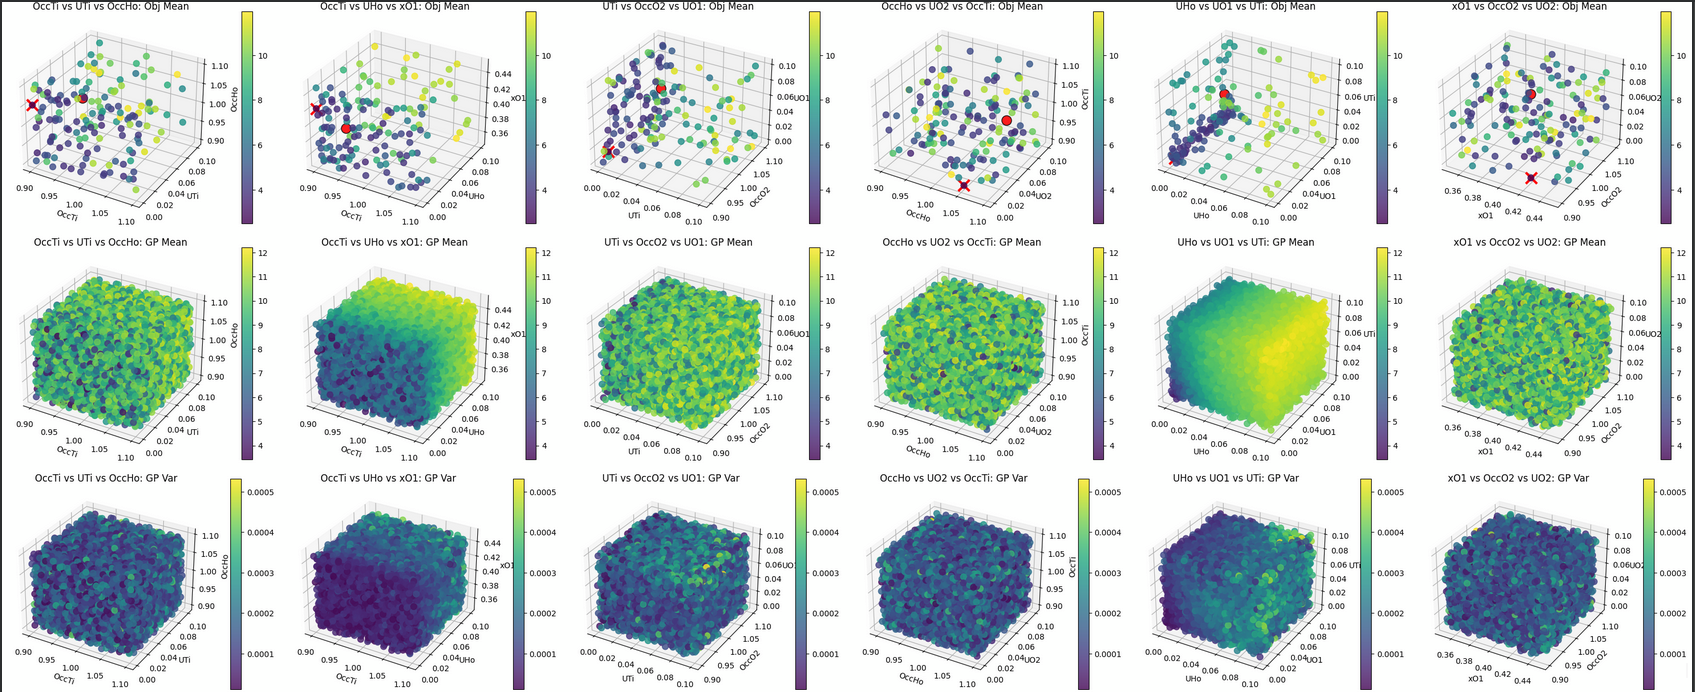

#########################################################

Current best solutions at iteration:$119$

Best params among evaluated samples:
$tensor([[0.9000, 0.0000, 1.0515, 0.0000, 0.4216, 0.9204, 0.0083, 0.0033]])$ $tensor(2.5200)$

In [ ]:
# Load the .npz file
data = np.load('hDim_VAEBO_results.npz')

# Print available array keys
print("Available arrays in file:", data.files)

# Extract arrays
X_opt        = data['X_opt']
X_opt_GP     = data['X_opt_GP']
train_X      = data['train_X']
train_Y      = data['train_Y']
train_chisq  = data['train_chisq']
y_pred_means = data['y_pred_means']
y_pred_vars  = data['y_pred_vars']

# Print shapes for quick inspection
print("\nArray shapes:")
print("X_opt:",        X_opt.shape)
print("X_opt_GP:",     X_opt_GP.shape)
print("train_X:",      train_X.shape)
print("train_Y:",      train_Y.shape)
print("test_X:",       test_X.shape)
print("train_chisq:",  train_chisq.shape)
print("y_pred_means:", y_pred_means.shape)
print("y_pred_vars:",  y_pred_vars.shape)

Available arrays in file: ['X_opt', 'X_opt_GP', 'train_X', 'train_Y', 'test_X', 'train_chisq', 'y_pred_means', 'y_pred_vars']

Array shapes:
X_opt: (1, 8)
X_opt_GP: (1, 8)
train_X: (169, 8)
train_Y: (169,)
test_X: torch.Size([10000, 8])
train_chisq: (169,)
y_pred_means: (10000,)
y_pred_vars: (10000,)
